# 实验三：参数估计 & 非参数估计
- 姓名：管昀玫
- 学号：2013750
- 专业：计算机科学与技术

## 基本要求

生成两个各包含 N=1200 个二维随机向量的数据集合  X1  和  X2 ，数据集合中随机向量来自于三个分布模型，分别满足均值向量  μ1=[1,4] , μ2=[4,1] ,  μ3=[8,4]  和协方差矩阵  D1=D2=D3=2II  ，其中 II 是  2∗2 的单位矩阵。在生成数据集合  X1  时，假设来自三个分布模型的先验概率相同 ；而在生成数据集合  X2  时，先验概率如下： p(w1)=0.6 ,  p(w2)=0.1 ,  p(w3)=0.3 
1. 在两个数据集合上分别应用“似然率测试规则” 、“最大后验概率规则” 进行分类实验，计算分类错误率，分析实验结果。
2. 在两个数据集合上分别应用  h=1  时的方窗核函数或高斯核函数估计方法，应用“似然率测试规则”进行分类实验，计算分类错误率，分析实验结果。

数据生成：由于我想使用矩阵运算，因此重写了一个标签和数据分离的数据生成函数（数据为x1,x2；标签为l1,l2）；但又由于在写中级要求的函数时混用了给定参考数据生成函数的数据（即数据本身和标签不分离），因此后文中两种数据都有使用。

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def split_data(m, cnt):
    x = [] 
    y = []
    for i in range(cnt):
        x.append(m[i][0])
        y.append(m[i][1])
    return x, y

In [3]:
def random_gen(cnt1, cnt2, cnt3, name): 
    cov = [[2, 0], [0, 2]]# 2I,2*2的单位矩阵
    # 使用np.random.multivariate产生数据
    # def multivariate_normal(mean, cov, size=None, check_valid=None, tol=None) 均值，协方差矩阵，维度
    a1 = np.random.multivariate_normal((1, 4), cov, cnt1)
    a2 = np.random.multivariate_normal((4, 1), cov, cnt2)
    a3 = np.random.multivariate_normal((8, 4), cov, cnt3)
    colors = ['#5eb8a4', '#c45252', '#6a71b0']
    area = np.pi   # 点面积
    x, y = split_data(a1, cnt1)
    plt.scatter(x, y, s=area, c=colors[0], alpha=0.4)
    x, y = split_data(a2, cnt2)
    plt.scatter(x, y, s=area, c=colors[1], alpha=0.4)
    x, y = split_data(a3, cnt3)
    plt.scatter(x, y, s=area, c=colors[2], alpha=0.4)
    ls = []
    result = []
    mean = np.array([[1, 4], [4, 1], [8, 4]])
    for i in range(cnt1):
        ls.append(a1[i])
        result.append(1)
    for i in range(cnt2):
        ls.append(a2[i])
        result.append(2)
    for i in range(cnt3):
        ls.append(a3[i])
        result.append(3)
    for i in range(3):
        plt.plot(mean[i][0], mean[i][1], 'r*')
    plt.figure(num = name) 
    return ls, result

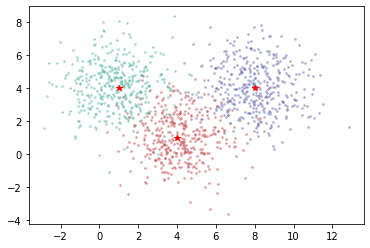

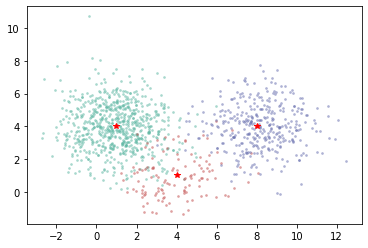

<Figure size 432x288 with 0 Axes>

In [4]:
x1, l1 = random_gen(400, 400, 400, "X_1数据集散点图")
x2, l2 = random_gen(720, 120, 360, "X_2数据集散点图")

In [5]:
# 生成正态分布数据
def Generate_Sample_Gaussian(mean, cov, P, label):
    '''
        mean 为均值向量
        cov 为方差矩阵a
        P 为单个类的先验概率
        return 单个类的数据集
    '''
    temp_num = round(1200 * P)
    x, y = np.random.multivariate_normal(mean, cov, temp_num).T
    z = np.ones(temp_num) * label
    X = np.array([x, y, z])
    return X.T

In [16]:
def Generate_DataSet_plot(mean, cov, P):
    # 画出不同先验对应的散点图
    xx = []
    label = 1
    for i in range(3):
        xx.append(Generate_Sample_Gaussian(mean[i], cov, P[i], label))
        label += 1
        i = i + 1
    '''
    # 画图
    plt.figure()
    for i in range(3):
        plt.plot(xx[i][:, 0], xx[i][:, 1], '.', markersize=4.)
        plt.plot(mean[i][0], mean[i][1], 'r*')
    plt.show()
    '''
    return xx

In [17]:
mean = np.array([[1, 4], [4, 1], [8, 4]])  # 均值数组
cov = [[2, 0], [0, 2]]  # 方差矩阵
num = 1200  # 样本个数
P1 = [1 / 3, 1 / 3, 1 / 3]  # 样本X1的先验概率
P2 = [0.6, 0.1, 0.3]  # 样本X2的先验概率
X1 = np.array(Generate_DataSet_plot(mean, cov, P1), dtype=object)
X2 = np.array(Generate_DataSet_plot(mean, cov, P2), dtype=object)
X1 = np.vstack(X1)
X2 = np.vstack(X2)

### 似然率测试规则(MLE)

根据公式$P(x)=\frac{1}{2\pi | \Sigma |^{1/2}} exp[(x-\mu)^T \Sigma^{-1}(x-\mu)]$

In [9]:
def likelyhood(data):
    x = np.mean(data, axis=0)
    cov = np.array([np.dot((data[i] - x).reshape(2,1), (data[i] - x).reshape(1, 2)) for i in range(len(data))]).mean(axis=0)
    return x,cov

In [10]:
def MLE(d, data, x, cov):
    res = 0
    h = np.linalg.det(cov)  # 计算方差矩阵的行列式
    temp = d - x
    res = np.exp(-1/2*np.dot(np.dot(temp, np.linalg.inv(cov)), temp.T))
    # result += math.exp(- (math.sqrt((x[0] - d[0]) ** 2 + (x[1] - d[1]) ** 2)) / (2 * h * h))
    res = res / (2 * np.pi * math.sqrt(h))
    return res

In [11]:
def simrate(ls1, ls2):
    num = 0
    l = len(ls1)
    for i in range(l):
        if ls1[i] != ls2[i]:
            num += 1
    return format(num / l, '.2%')

In [12]:
def MLE_classify(data, m1, m2, m3):
    data1 = data[0 : m1]
    data2 = data[m1 : m1+m2]
    data3 = data[m1+m2 : m1+m2+m3]
    x1, cov1 = likelyhood(data1)
    x2, cov2 = likelyhood(data2)
    x3, cov3 = likelyhood(data3)
    print("mu1和sigma1分别为：",x1,cov1)
    print("mu2和sigma2分别为：",x2,cov2)
    print("mu3和sigma3分别为：",x3,cov3)
    result = []
    for d in data:
        t1 = MLE(d,data,x1,cov1)
        t2 = MLE(d,data,x2,cov2)
        t3 = MLE(d,data,x3,cov3)
        i = 1
        max = t1
        if t2 > max:
            max = t2
            i = 2
        if t3 > max:
            max = t3
            i = 3
        result.append(i)
    return result

In [13]:
def show_result(data, result, name):
    colors = ['#5eb8a4', '#c45252', '#6a71b0']
    area = np.pi   # 点面积
    x1 = []
    x2 = []
    x3 = []
    y1 = []
    y2 = []
    y3 = []
    for i in range(len(data)):
        if result[i] == 1:
            x1.append(data[i][0])
            y1.append(data[i][1])
        elif result[i] == 2:
            x2.append(data[i][0])
            y2.append(data[i][1])
        elif result[i] == 3:
            x3.append(data[i][0])
            y3.append(data[i][1])
    plt.scatter(x1, y1, s=area, c=colors[0], alpha=0.4)
    plt.scatter(x2, y2, s=area, c=colors[1], alpha=0.4)
    plt.scatter(x3, y3, s=area, c=colors[2], alpha=0.4)
    plt.figure(num = name)

mu1和sigma1分别为： [0.83308343 4.16317965] [[1.92778022 0.07556535]
 [0.07556535 2.03960053]]
mu2和sigma2分别为： [4.13121806 1.06215744] [[ 1.84714853 -0.03662706]
 [-0.03662706  2.07672088]]
mu3和sigma3分别为： [7.9934033  4.05433716] [[ 2.01341604 -0.1527506 ]
 [-0.1527506   2.23297348]]
mu1和sigma1分别为： [0.98067572 3.97401349] [[ 1.98703406 -0.17140278]
 [-0.17140278  2.05532376]]
mu2和sigma2分别为： [3.98158612 0.93874044] [[2.19896784 0.36016432]
 [0.36016432 1.57132067]]
mu3和sigma3分别为： [8.14694998 4.00273617] [[ 2.11252889 -0.02761611]
 [-0.02761611  1.90221306]]


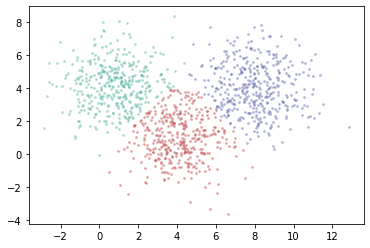

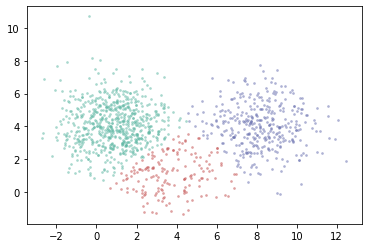

<Figure size 432x288 with 0 Axes>


X_1数据集使用似然率测试规则进行分类的错误率是 6.42%
X_2数据集使用似然率测试规则进行分类的错误率是 6.33%


In [15]:
result1 = MLE_classify(x1, 400, 400, 400)
result2 = MLE_classify(x2, 720, 120, 360)

Error_rate1 = simrate(result1, l1)
Error_rate2 = simrate(result2, l2)

show_result(x1, result1, "X_1似然率测试规则分类图")
show_result(x2, result2, "X_2似然率测试规则分类图")


plt.show()

print("\nX_1数据集使用似然率测试规则进行分类的错误率是", Error_rate1)
print("X_2数据集使用似然率测试规则进行分类的错误率是", Error_rate2)

### 最大后验概率规则

根据概率密度公式$\frac{1}{\sqrt{2 \pi}\sigma}e^{-\frac{(\theta-u)^2}{2\sigma. ^2}}$进行计算

In [18]:
def MAP(data, m):
    m = np.array(m)
    cov = np.array([[2, 0], [0, 2]])
    return 1 / math.sqrt((2 * np.pi) ** 2 * 1) * math.exp(-0.5 * np.dot((data - m).T, (data - m))) 

In [19]:
def MAP_classify(data, mean1, mean2, mean3):
    result = []
    for d in data:
        t1 = MAP(d, mean1)
        t2 = MAP(d, mean2)
        t3 = MAP(d, mean3)
        i = 1
        max = t1
        if t2 > max:
            max = t2
            i = 2
        if t3 > max:
            max = t3
            i = 3
        result.append(i)
    return result

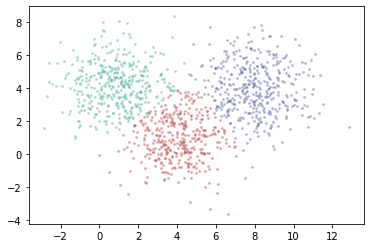

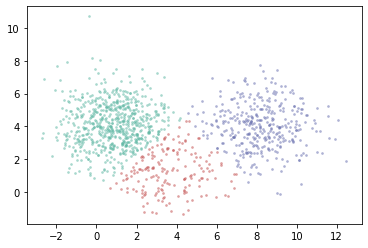

<Figure size 432x288 with 0 Axes>


X_1数据集使用最大后验概率规则进行分类的错误率是 6.17%
X_2数据集使用最大后验概率规则进行分类的错误率是 6.83%


In [20]:
result1 = MAP_classify(x1, (1, 4), (4, 1), (8, 4))
result2 = MAP_classify(x2, (1, 4), (4, 1), (8, 4))

Error_rate1 = simrate(result1, l1)
Error_rate2 = simrate(result2, l2)

show_result(x1, result1, "X_1最大后验概率规则分类图")
show_result(x2, result2, "X_2最大后验概率规则分类图")


plt.show()

print("\nX_1数据集使用最大后验概率规则进行分类的错误率是", Error_rate1)
print("X_2数据集使用最大后验概率规则进行分类的错误率是", Error_rate2)

#### 分析实验结果
可以看到，MLE估计的错误率6.42%和6.33%，而MAP的错误率大致为6.17%和6.83%，二者相差不大。

### h = 1高斯核函数 似然率试验规则

In [21]:
def guss(x, data, h):
    n = len(data)
    result = 0
    for i in range(n):
        result += math.exp(- (math.sqrt((x[0] - data[i][0]) ** 2 + (x[1] - data[i][1]) ** 2)) / (2 * h * h))
    result = result / (n * math.sqrt(2 * np.pi * h * h))
    return result

In [22]:
def MLE_classify_with_guss(data, m1, m2, m3, h, r):
    result = []
    data1 = data[0 : m1]
    data2 = data[m1 : m1+m2]
    data3 = data[m1+m2 : m1+m2+m3]
    for d in data:
        t1 = guss(d, data1, h)
        t2 = guss(d, data2, h)
        t3 = guss(d, data3, h)
        i = 1
        max = t1
        if t2 > max:
            max = t2
            i = 2
        if t3 > max:
            max = t3
            i = 3
        result.append(i)
    return simrate(result, r)

In [24]:
r1_10 = MLE_classify_with_guss(x1, 400, 400, 400, 1, l1)
r2_10 = MLE_classify_with_guss(x2, 720, 120, 360, 1, l2)

print("X_1数据集利用似然率测试规则在h = 1.0情况下分类错误率是 ", r1_10)
print("X_2数据集利用似然率测试规则在h = 1.0情况下分类错误率是 ", r2_10)

X_1数据集利用似然率测试规则在h = 1.0情况下分类错误率是  6.25%
X_2数据集利用似然率测试规则在h = 1.0情况下分类错误率是  6.58%


#### 实验结果分析
从结果中可以看出，使用高斯核函数估计方法，应用“似然率测试规则”，分类错误率大致为6.25%和6.58%，和之前不使用核函数的MLE和MAP结果大致相近。第一个数据集的错误率有稍微降低，说明在此数据集上适应良好。

### 中级要求
根据初级要求中使用的一个核函数，在数据集  X2 上应用交叉验证法，在  h∈[0.1,0.5,1,1.5,2]  中寻找最优的h值。

此处为了方便，使用留一法。

In [25]:
def MLE_classify_with_guss_loo(data, m1, m2, m3, h, r):
    result = []
    data1 = data[0 : m1]
    data2 = data[m1 : m1+m2]
    data3 = data[m1+m2 : m1+m2+m3]
    # 交叉验证：留一法
    for i in range(0, len(data)-1):
        d = data[i]
        if(i<m1-1):
            data1 = np.vstack((data[0:i],data[i+1:m1]))
            data2 = data[m1 : m1+m2]
            data3 = data[m1+m2 : m1+m2+m3]
        elif(i>=m1 and i<m1+m2-1):
            data1 = data[0 : m1]
            data2 = np.vstack((data[m1:i],data[i+1:m1+m2]))
            data3 = data[m1+m2 : m1+m2+m3]
        elif(i>=m1+m2 and i < m1+m2+m3):            
            data1 = data[0 : m1]
            data2 = data[m1 : m1+m2]
            data3 = np.vstack((data[m1+m2:i],data[i+1:m1+m2+m3]))
            
        t1 = guss(d, data1, h)
        t2 = guss(d, data2, h)
        t3 = guss(d, data3, h)
        i = 1
        max = t1
        if t2 > max:
            max = t2
            i = 2
        if t3 > max:
            max = t3
            i = 3
        result.append(i)
    return simrate(result, r)

In [34]:
error_rate = [0, 0, 0, 0, 0]
error_rate[0] = MLE_classify_with_guss_loo(X2, 720, 120, 360, 0.1, l2)
error_rate[1] = MLE_classify_with_guss_loo(X2, 720, 120, 360, 0.5, l2)
error_rate[2] = MLE_classify_with_guss_loo(X2, 720, 120, 360, 1, l2)
error_rate[3] = MLE_classify_with_guss_loo(X2, 720, 120, 360, 1.5, l2)
error_rate[4] = MLE_classify_with_guss_loo(X2, 720, 120, 360, 2, l2)
print("x2使用高斯核函数、MLE估计方法，在h = 0.1情况下分类错误率是 ", error_rate[0])
print("x2使用高斯核函数、MLE估计方法，在h = 0.5情况下分类错误率是 ", error_rate[1])
print("x2使用高斯核函数、MLE估计方法，在h = 1.0情况下分类错误率是 ", error_rate[2])
print("x2使用高斯核函数、MLE估计方法，在h = 1.5情况下分类错误率是 ", error_rate[3])
print("x2使用高斯核函数、MLE估计方法，在h = 2.0情况下分类错误率是 ", error_rate[4])

x2使用高斯核函数、MLE估计方法，在h = 0.1情况下分类错误率是  7.34%
x2使用高斯核函数、MLE估计方法，在h = 0.5情况下分类错误率是  5.92%
x2使用高斯核函数、MLE估计方法，在h = 1.0情况下分类错误率是  6.76%
x2使用高斯核函数、MLE估计方法，在h = 1.5情况下分类错误率是  6.92%
x2使用高斯核函数、MLE估计方法，在h = 2.0情况下分类错误率是  6.92%


#### 最优h值
由结果可知，在h = 0.5时，错误率最低。在h<0.5和h>0.5处错误率都有所升高。因此最优h值为0.5。

### 高级要求
任选一个数据集，在该数据集上应用k-近邻概率密度估计，任选3个k值输出概率密度分布图。

此处选用X1数据集，选用的三个k值分别为：k=[20, 10, 3]

In [27]:
def Kneibor_Eval(X, k):
    num = len(X)
    Xtrain = np.array(X)
    shape = X.shape[0]
    # 生成200*200=40000个采样点，每个采样点对应三类的不同概率
    p = np.zeros((200, 200, 3))
    # 在[-5,15]的范围内，以0.1为步长估计概率密度
    for i in np.arange(0, 200):
        for j in np.arange(0, 200):
            '''
            # 生成标准差距离
            # 根据第k个数据点的位置计算V
            # 找到前k个数据点的类别,分别加到对应类的权重上
            # 计算每个采样点的概率密度函数
            
            '''
            dist = []
            x = -5 + 0.1 * i
            y = -5 + 0.1 * j
            dist = []
            for m in range(X.shape[0]):
                dist.append(math.sqrt((X[m][0]-x)**2+(X[m][1]-y)**2))
            sortIndex = np.argsort(dist)
            V = math.pi * (dist[sortIndex[k]] ** 2)
            weight = [0, 0, 0]
            for l in range(k):
                if X[sortIndex[l]][2] == 1:
                    weight[0] += 1
                if X[sortIndex[l]][2] == 2:
                    weight[1] += 1
                if X[sortIndex[l]][2] == 3:
                    weight[2] += 1
            p[i][j][0] = weight[0] / V / shape
            p[i][j][1] = weight[1] / V / shape
            p[i][j][2] = weight[2] / V / shape
    return p

In [28]:
p = Kneibor_Eval(X1, 20)  # 获得概率密度估计

# 高级要求1
X,Y = np.mgrid[-5:15:200j, -5:15:200j]

Z0 = p[:, :, 0]
Z1 = p[:, :, 1]
Z2 = p[:, :, 2]

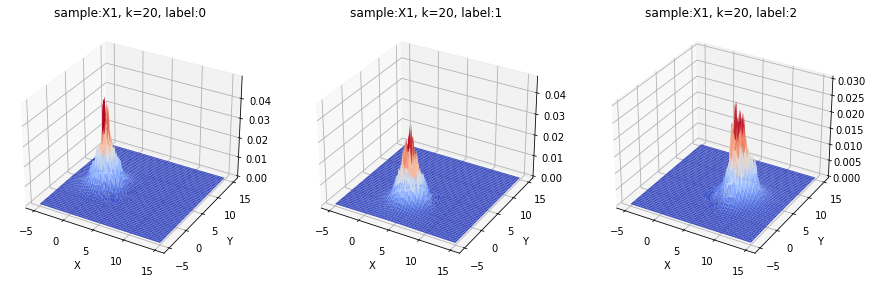

In [29]:
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1, 3, 1,projection='3d')
ax.plot_surface(X, Y, Z0,cmap=plt.cm.coolwarm)
ax.set_title("sample:X1, k=20, label:0")
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax = plt.subplot(1, 3, 2,projection='3d')
ax.plot_surface(X, Y, Z1,cmap=plt.cm.coolwarm)
ax.set_title("sample:X1, k=20, label:1")
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax = plt.subplot(1, 3, 3,projection='3d')
ax.plot_surface(X, Y, Z2,cmap=plt.cm.coolwarm)
ax.set_title("sample:X1, k=20, label:2")
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

In [30]:
p = Kneibor_Eval(X1, 10)  # 获得概率密度估计

# 高级要求1
X,Y = np.mgrid[-5:15:200j, -5:15:200j]

Z0 = p[:, :, 0]
Z1 = p[:, :, 1]
Z2 = p[:, :, 2]

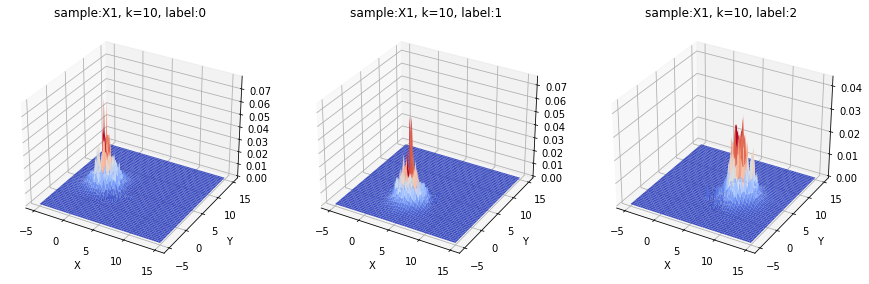

In [31]:
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1, 3, 1,projection='3d')
ax.plot_surface(X, Y, Z0,cmap=plt.cm.coolwarm)
ax.set_title("sample:X1, k=10, label:0")
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax = plt.subplot(1, 3, 2,projection='3d')
ax.plot_surface(X, Y, Z1,cmap=plt.cm.coolwarm)
ax.set_title("sample:X1, k=10, label:1")
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax = plt.subplot(1, 3, 3,projection='3d')
ax.plot_surface(X, Y, Z2,cmap=plt.cm.coolwarm)
ax.set_title("sample:X1, k=10, label:2")
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

In [32]:
p = Kneibor_Eval(X1, 3)  # 获得概率密度估计

# 高级要求1
X,Y = np.mgrid[-5:15:200j, -5:15:200j]

Z0 = p[:, :, 0]
Z1 = p[:, :, 1]
Z2 = p[:, :, 2]

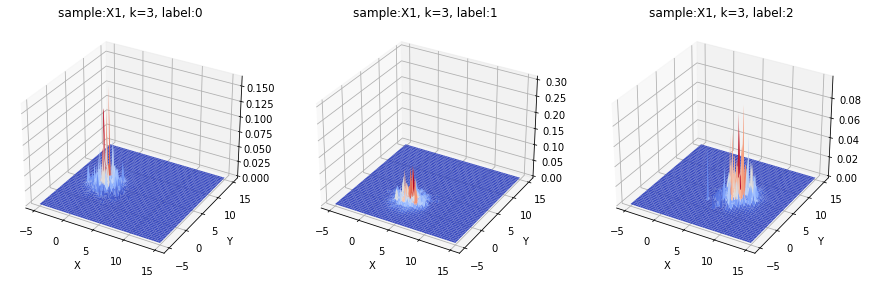

In [33]:
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1, 3, 1,projection='3d')
ax.plot_surface(X, Y, Z0,cmap=plt.cm.coolwarm)
ax.set_title("sample:X1, k=3, label:0")
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax = plt.subplot(1, 3, 2,projection='3d')
ax.plot_surface(X, Y, Z1,cmap=plt.cm.coolwarm)
ax.set_title("sample:X1, k=3, label:1")
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax = plt.subplot(1, 3, 3,projection='3d')
ax.plot_surface(X, Y, Z2,cmap=plt.cm.coolwarm)
ax.set_title("sample:X1, k=3, label:2")
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()